In [1]:
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader

from models.edge_detector import UnetLikeEdgeDetector
from utilities.edge_dataset import EdgeDetectionDataset
from utilities.metrics import precision_recall_f1
from utilities.plots import plot_images_in_row

In [2]:
batch_size = 8
test_dataset = EdgeDetectionDataset(path="data/test")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [3]:
path_to_weights = "model_weights/unet_like_another60"

model = UnetLikeEdgeDetector()
model.load_state_dict(torch.load(
    path_to_weights, 
    weights_only=True, 
    map_location=torch.device('cpu')
))

<All keys matched successfully>

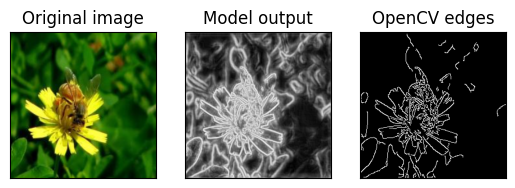

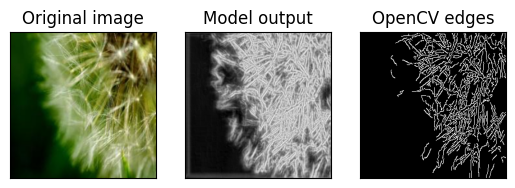

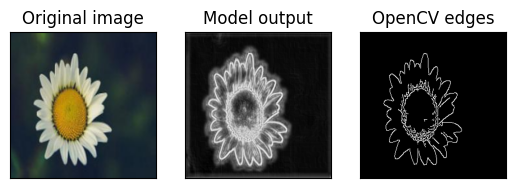

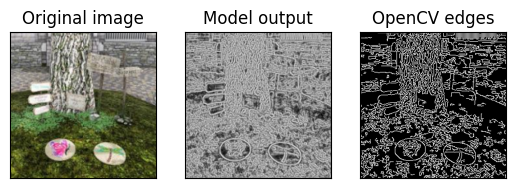

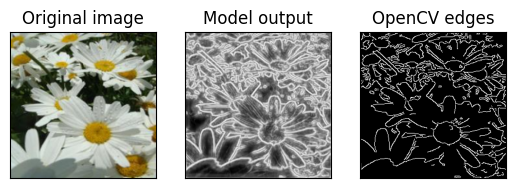

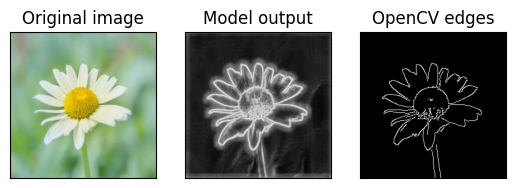

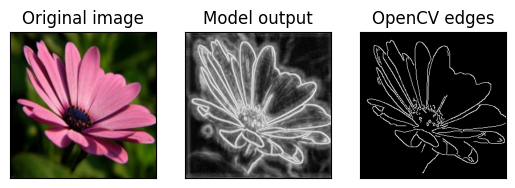

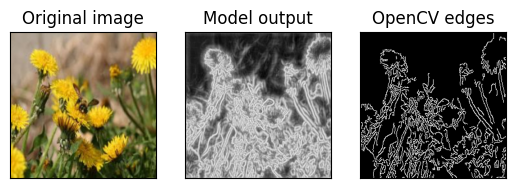

In [4]:
model.eval()

image, target = next(iter(test_loader))
output = model(image)

for i in range(batch_size):
    model_output = output[i][0].detach().numpy()
    transposed_image = np.transpose(image[i].numpy(), (1, 2, 0))
    opencv_edges = cv2.Canny((transposed_image * 255).astype(np.uint8), 100, 200)

    plot_images_in_row(
        images=[transposed_image, model_output, opencv_edges], 
        titles=["Original image", "Model output", "OpenCV edges"]
    )

In [5]:
precisions = []
recalls = []
f1_scores = []

for image, _ in test_loader:
    output = model(image)

    for i in range(output.shape[0]):
        model_output = output[i][0].detach().numpy()
        transposed_image = np.transpose(image[i].detach().numpy(), (1, 2, 0))
        opencv_edges = cv2.Canny((transposed_image * 255).astype(np.uint8), 100, 200)

        precision, recall, f1_score = precision_recall_f1(model_output, 
                                                          opencv_edges)
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)

print(f"Average precision: {sum(precisions) / len(precisions):.4f}")
print(f"Average recall: {sum(recalls) / len(recalls):.4f}")
print(f"Average f1-score: {sum(f1_scores) / len(f1_scores):.4f}")


Average precision: 0.7395
Average recall: 0.7113
Average f1-score: 0.7222
